# CS324: Deep Learning  Assignment 3

# Part I: PyTorch LSTM (40 points)


## 1.1 Task 1
Implement the LSTM without using torch.nn.LSTM. Follow the skeleton provided in train.py (for the training)
and lstm.py (to define the model). For the forward pass you will need to use a for loop to step through time and
apply the recurrence equations that define the network behaviour. For the backward pass you can rely on Pytorch
automatic differentiation and use the RMSProp optimiser for tuning the weights.

## 1. Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import math

# Import local modules
from dataset import PalindromeDataset
from lstm import LSTM
from utils import AverageMeter, accuracy

print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA device: {torch.cuda.get_device_name(0)}')

PyTorch version: 2.6.0+cu126
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU


## 2. LSTM Mathematical Principles

LSTM processes sequence data through the following equations:

$$
\begin{aligned}
g^{(t)} &= \tanh(W_{gx}x^{(t)} + W_{gh}h^{(t-1)} + b_g) \quad &\text{(Input Modulation)} \\
i^{(t)} &= \sigma(W_{ix}x^{(t)} + W_{ih}h^{(t-1)} + b_i) \quad &\text{(Input Gate)} \\
f^{(t)} &= \sigma(W_{fx}x^{(t)} + W_{fh}h^{(t-1)} + b_f) \quad &\text{(Forget Gate)} \\
o^{(t)} &= \sigma(W_{ox}x^{(t)} + W_{oh}h^{(t-1)} + b_o) \quad &\text{(Output Gate)} \\
c^{(t)} &= g^{(t)} \odot i^{(t)} + c^{(t-1)} \odot f^{(t)} \quad &\text{(Cell State)} \\
h^{(t)} &= \tanh(c^{(t)}) \odot o^{(t)} \quad &\text{(Hidden State)} \\
p^{(t)} &= W_{ph}h^{(t)} + b_p \quad &\text{(Prediction Logits)} \\
\tilde{y}^{(t)} &= \text{softmax}(p^{(t)}) \quad &\text{(Output Probabilities)}
\end{aligned}
$$

where $\odot$ denotes element-wise multiplication.

## 3. Understanding the Dataset

The palindrome dataset generates palindromic digit sequences, for example:
- Length 5: `[1,2,3,2,1]`
- Length 7: `[0,1,2,3,2,1,0]`

The task is to predict the last digit given the first N digits.

In [2]:
# Create a small dataset to view samples
sample_dataset = PalindromeDataset(input_length=5, total_len=10, one_hot=False)

print("Dataset Sample Display:")
print("=" * 60)
for i in range(5):
    inputs, label = sample_dataset[i]
    input_digits = inputs.squeeze().astype(int)
    print(f"Sample {i+1}:")
    print(f"  Input sequence: {input_digits}")
    print(f"  Target label: {label}")
    print(f"  Complete palindrome: {np.append(input_digits, label)}")
    print()

Dataset Sample Display:
Sample 1:
  Input sequence: [1 5 4 4 5]
  Target label: 1
  Complete palindrome: [1 5 4 4 5 1]

Sample 2:
  Input sequence: [3 5 9 9 5]
  Target label: 3
  Complete palindrome: [3 5 9 9 5 3]

Sample 3:
  Input sequence: [0 3 3 3 3]
  Target label: 0
  Complete palindrome: [0 3 3 3 3 0]

Sample 4:
  Input sequence: [8 9 3 3 9]
  Target label: 8
  Complete palindrome: [8 9 3 3 9 8]

Sample 5:
  Input sequence: [8 3 7 7 3]
  Target label: 8
  Complete palindrome: [8 3 7 7 3 8]



## 4. Configure Hyperparameters

In [3]:
# Configuration parameters
class Config:
    input_length = 9  # Input sequence length (first 9 digits of palindrome)
    input_dim = 1  # Input dimension per time step
    num_classes = 10  # Number of output classes (digits 0-9)
    num_hidden = 128  # LSTM hidden layer dimension
    batch_size = 128  # Batch size
    learning_rate = 0.001  # Learning rate
    max_epoch = 10  # Number of training epochs (for demo, can be larger)
    max_norm = 10.0  # Gradient clipping threshold
    data_size = 10000  # Dataset size
    portion_train = 0.8  # Training set proportion

config = Config()

print("Training Configuration:")
print("=" * 60)
for key, value in vars(config).items():
    print(f"{key:20s}: {value}")

Training Configuration:


## 5. Initialize Model and Data

In [4]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}\n')

# Initialize model
model = LSTM(
    seq_length=config.input_length + 1,
    input_dim=config.input_dim,
    hidden_dim=config.num_hidden,
    output_dim=config.num_classes,
    batch_size=config.batch_size
)
model.to(device)

# Print model structure
print("Model Structure:")
print("=" * 60)
print(model)
print("\nModel Parameters Statistics:")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda

Model Structure:
LSTM(
  (gx): Linear(in_features=1, out_features=128, bias=True)
  (gh): Linear(in_features=128, out_features=128, bias=True)
  (ix): Linear(in_features=1, out_features=128, bias=True)
  (ih): Linear(in_features=128, out_features=128, bias=True)
  (fx): Linear(in_features=1, out_features=128, bias=True)
  (fh): Linear(in_features=128, out_features=128, bias=True)
  (ox): Linear(in_features=1, out_features=128, bias=True)
  (oh): Linear(in_features=128, out_features=128, bias=True)
  (ph): Linear(in_features=128, out_features=10, bias=True)
)

Model Parameters Statistics:
Total parameters: 68,362
Trainable parameters: 68,362


In [5]:
# Create dataset
dataset = PalindromeDataset(
    input_length=config.input_length,
    total_len=config.data_size,
    one_hot=False
)

# Split dataset into train and validation sets
train_size = int(config.portion_train * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    drop_last=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    drop_last=True
)

print("Dataset Information:")
print("=" * 60)
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Dataset Information:
Training samples: 8000
Validation samples: 2000
Training batches: 62
Validation batches: 15


## 6. Setup Loss Function and Optimizer

In [6]:
# Loss function: Cross Entropy
criterion = nn.CrossEntropyLoss()

# Optimizer: RMSProp
optimizer = torch.optim.RMSprop(
    model.parameters(),
    lr=config.learning_rate
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.9
)

print("Optimizer Configuration:")
print("=" * 60)
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: RMSProp")
print(f"Initial learning rate: {config.learning_rate}")
print(f"Learning rate decay: 0.9x every 10 epochs")

Optimizer Configuration:
Loss function: CrossEntropyLoss
Optimizer: RMSProp
Initial learning rate: 0.001
Learning rate decay: 0.9x every 10 epochs


## 7. Define Training and Evaluation Functions

In [7]:
def train_epoch(model, data_loader, optimizer, criterion, device, config):
    """Train for one epoch"""
    model.train()
    losses = AverageMeter("Loss")
    accuracies = AverageMeter("Accuracy")
    
    for step, (batch_inputs, batch_targets) in enumerate(data_loader):
        # Move data to device
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping (prevent gradient explosion)
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=config.max_norm)
        
        # Update weights
        optimizer.step()
        
        # Calculate accuracy
        acc = accuracy(outputs, batch_targets)
        losses.update(loss.item(), batch_inputs.size(0))
        accuracies.update(acc, batch_inputs.size(0))
    
    return losses.avg, accuracies.avg


@torch.no_grad()
def evaluate(model, data_loader, criterion, device):
    """Evaluate model"""
    model.eval()
    losses = AverageMeter("Loss")
    accuracies = AverageMeter("Accuracy")
    
    for batch_inputs, batch_targets in data_loader:
        # Move data to device
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        
        # Forward pass
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        
        # Calculate accuracy
        acc = accuracy(outputs, batch_targets)
        losses.update(loss.item(), batch_inputs.size(0))
        accuracies.update(acc, batch_inputs.size(0))
    
    return losses.avg, accuracies.avg

print("Training and evaluation functions defined!")

Training and evaluation functions defined!


## 8. Start Training

**Important**: Make sure you have executed ALL previous cells (1-7) before running this cell. The training requires:
- Model initialized (cell 5)
- Dataset and data loaders created (cell 5, second code block)
- Loss function and optimizer configured (cell 6)
- Training functions defined (cell 7)

In [8]:
# Record training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("Start training...")
print("=" * 60)

for epoch in range(config.max_epoch):
    print(f"\nEpoch [{epoch+1}/{config.max_epoch}]")
    print("-" * 60)
    
    # Train for one epoch
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, criterion, device, config
    )
    
    # Evaluate model
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print results
    print(f"Training - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"Validation - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Update learning rate
    scheduler.step()

print("\n" + "=" * 60)
print("Training completed!")

Start training...

Epoch [1/10]
------------------------------------------------------------
Training - Loss: 2.1926, Acc: 26.23%
Validation - Loss: 2.0149, Acc: 49.79%
Learning rate: 0.001000

Epoch [2/10]
------------------------------------------------------------
Training - Loss: 1.9371, Acc: 54.76%
Validation - Loss: 2.0081, Acc: 43.28%
Learning rate: 0.001000

Epoch [3/10]
------------------------------------------------------------
Training - Loss: 1.8474, Acc: 64.24%
Validation - Loss: 1.8029, Acc: 68.44%
Learning rate: 0.001000

Epoch [4/10]
------------------------------------------------------------
Training - Loss: 1.7751, Acc: 69.49%
Validation - Loss: 1.7453, Acc: 73.75%
Learning rate: 0.001000

Epoch [5/10]
------------------------------------------------------------
Training - Loss: 1.7462, Acc: 74.80%
Validation - Loss: 1.6623, Acc: 89.43%
Learning rate: 0.001000

Epoch [6/10]
------------------------------------------------------------
Training - Loss: 1.6512, Acc: 88

## 9. Visualize Training Process

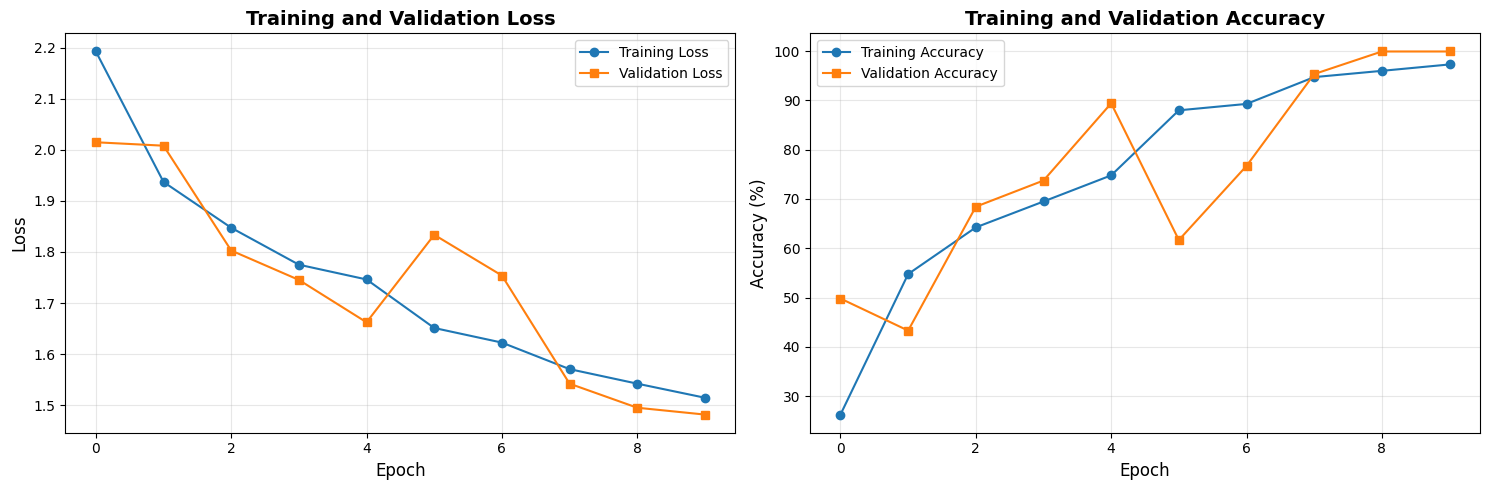


Final Results:
Best training accuracy: 97.32%
Best validation accuracy: 99.95%
Final training loss: 1.5146
Final validation loss: 1.4816


In [9]:
# Create training history visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
axes[0].plot(history['train_loss'], label='Training Loss', marker='o')
axes[0].plot(history['val_loss'], label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(history['train_acc'], label='Training Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Validation Accuracy', marker='s')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results
print("\nFinal Results:")
print("=" * 60)
print(f"Best training accuracy: {max(history['train_acc']):.2f}%")
print(f"Best validation accuracy: {max(history['val_acc']):.2f}%")
print(f"Final training loss: {history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {history['val_loss'][-1]:.4f}")

## 10. Test Model Predictions

In [10]:
# Create test samples
@torch.no_grad()
def test_predictions(model, dataset, device, num_samples=10):
    """Test model predictions"""
    model.eval()
    
    print("Model Prediction Test:")
    print("=" * 80)
    
    correct = 0
    for i in range(num_samples):
        inputs, label = dataset[i]
        
        # Prepare input
        inputs_tensor = torch.from_numpy(inputs).unsqueeze(0).to(device)
        
        # Predict
        output = model(inputs_tensor)
        pred = output.argmax(dim=1).item()
        confidence = output[0, pred].item() * 100
        
        # Display results
        input_digits = inputs.squeeze().astype(int)
        is_correct = pred == label
        correct += int(is_correct)
        
        status = "✓" if is_correct else "✗"
        print(f"Sample {i+1:2d} {status}:")
        print(f"  Input sequence: {input_digits}")
        print(f"  True label: {label}")
        print(f"  Prediction: {pred} (Confidence: {confidence:.1f}%)")
        if not is_correct:
            print(f"  ❌ Incorrect prediction!")
        print()
    
    accuracy = 100.0 * correct / num_samples
    print("=" * 80)
    print(f"Test accuracy: {correct}/{num_samples} = {accuracy:.1f}%")
    return accuracy

# Test 20 samples
test_acc = test_predictions(model, dataset, device, num_samples=20)

Model Prediction Test:
Sample  1 ✓:
  Input sequence: [0 9 5 0 1 1 0 5 9]
  True label: 0
  Prediction: 0 (Confidence: 99.9%)

Sample  2 ✓:
  Input sequence: [2 8 6 4 3 3 4 6 8]
  True label: 2
  Prediction: 2 (Confidence: 99.9%)

Sample  3 ✓:
  Input sequence: [7 8 3 4 9 9 4 3 8]
  True label: 7
  Prediction: 7 (Confidence: 93.8%)

Sample  4 ✓:
  Input sequence: [9 6 0 0 9 9 0 0 6]
  True label: 9
  Prediction: 9 (Confidence: 95.7%)

Sample  5 ✓:
  Input sequence: [3 6 6 1 1 1 1 6 6]
  True label: 3
  Prediction: 3 (Confidence: 99.7%)

Sample  6 ✓:
  Input sequence: [1 9 5 0 8 8 0 5 9]
  True label: 1
  Prediction: 1 (Confidence: 99.9%)

Sample  7 ✓:
  Input sequence: [7 9 9 3 5 5 3 9 9]
  True label: 7
  Prediction: 7 (Confidence: 92.8%)

Sample  8 ✓:
  Input sequence: [2 7 6 5 6 6 5 6 7]
  True label: 2
  Prediction: 2 (Confidence: 99.8%)

Sample  9 ✓:
  Input sequence: [9 0 9 7 6 6 7 9 0]
  True label: 9
  Prediction: 9 (Confidence: 96.4%)

Sample 10 ✓:
  Input sequence: [4 3 8 8 2

## 11. Analyze LSTM Internal Mechanisms

Let's visualize the gate activations as a sample passes through the LSTM.

Visualizing Sample:
Input sequence: [0 9 5 0 1 1 0 5 9]
Target label: 0



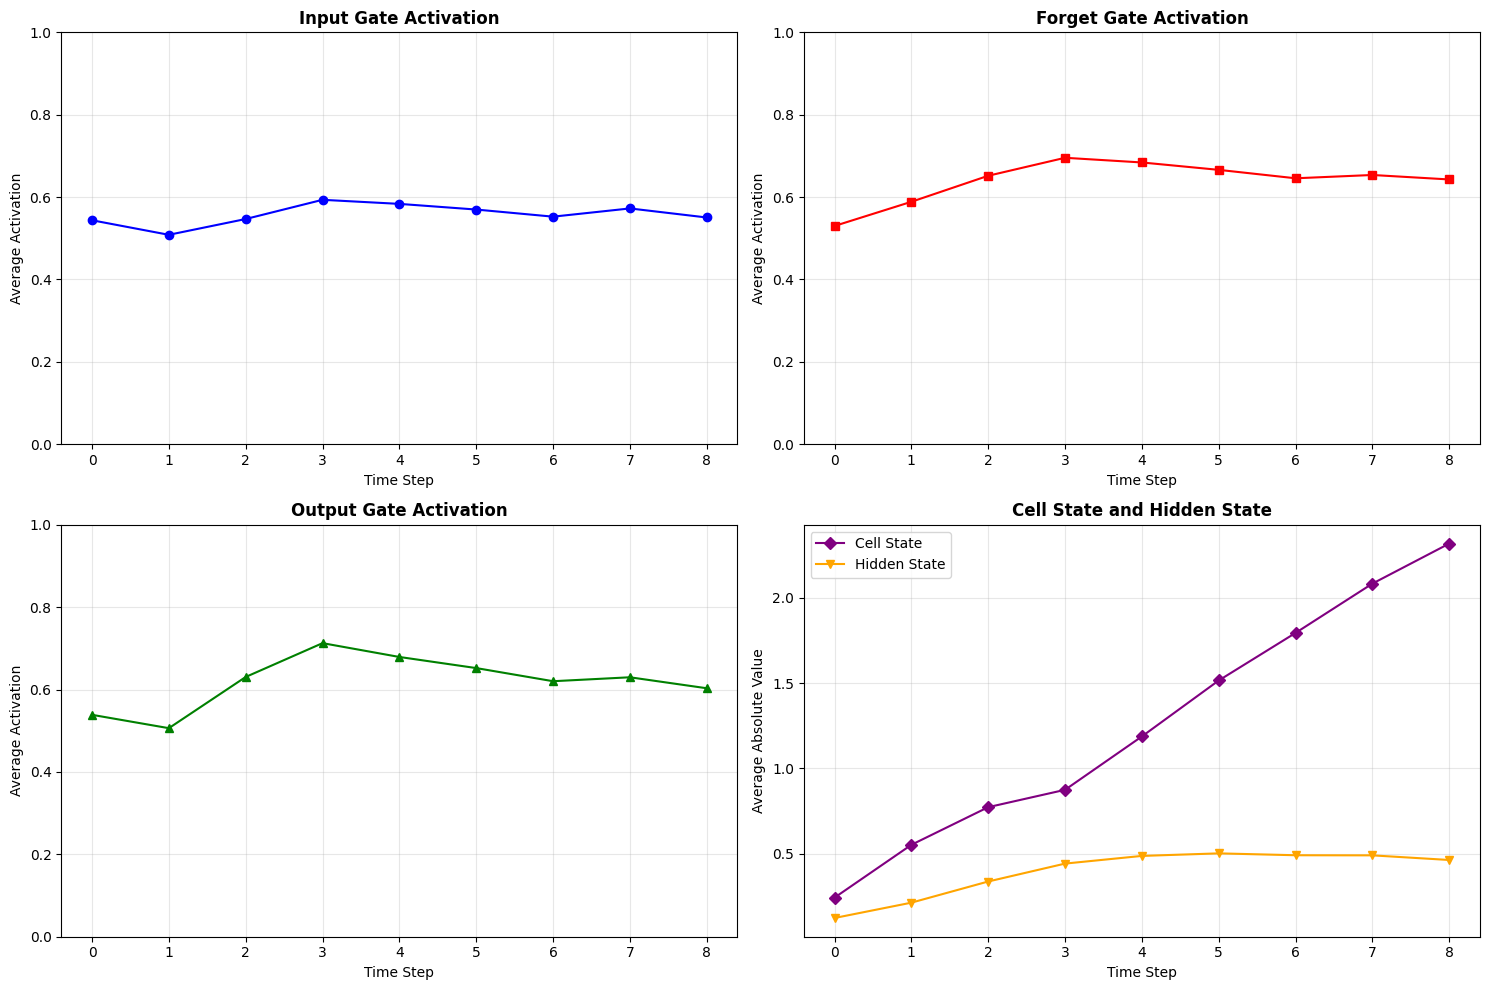

In [11]:
# Modify LSTM to record internal states
@torch.no_grad()
def visualize_lstm_gates(model, sample_input, device):
    """Visualize LSTM gate activations"""
    model.eval()
    
    # Prepare input
    x = sample_input.unsqueeze(0).to(device)
    batch_size = x.size(0)
    seq_length = x.size(1)
    
    # Initialize states
    h = torch.zeros(batch_size, model.hidden_dim).to(device)
    c = torch.zeros(batch_size, model.hidden_dim).to(device)
    
    # Record gate activations
    gate_activations = {
        'input_gate': [],
        'forget_gate': [],
        'output_gate': [],
        'cell_state': [],
        'hidden_state': []
    }
    
    # Step-by-step forward pass
    for t in range(seq_length):
        x_t = x[:, t, :]
        
        g = model.tanh(model.gx(x_t) + model.gh(h))
        i = model.sig(model.ix(x_t) + model.ih(h))
        f = model.sig(model.fx(x_t) + model.fh(h))
        o = model.sig(model.ox(x_t) + model.oh(h))
        
        c = g * i + c * f
        h = model.tanh(c) * o
        
        # Record average activation values
        gate_activations['input_gate'].append(i.mean().item())
        gate_activations['forget_gate'].append(f.mean().item())
        gate_activations['output_gate'].append(o.mean().item())
        gate_activations['cell_state'].append(c.abs().mean().item())
        gate_activations['hidden_state'].append(h.abs().mean().item())
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Input gate
    axes[0, 0].plot(gate_activations['input_gate'], marker='o', color='blue')
    axes[0, 0].set_title('Input Gate Activation', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Time Step')
    axes[0, 0].set_ylabel('Average Activation')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([0, 1])
    
    # Forget gate
    axes[0, 1].plot(gate_activations['forget_gate'], marker='s', color='red')
    axes[0, 1].set_title('Forget Gate Activation', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Time Step')
    axes[0, 1].set_ylabel('Average Activation')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim([0, 1])
    
    # Output gate
    axes[1, 0].plot(gate_activations['output_gate'], marker='^', color='green')
    axes[1, 0].set_title('Output Gate Activation', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Time Step')
    axes[1, 0].set_ylabel('Average Activation')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 1])
    
    # Cell state and hidden state
    axes[1, 1].plot(gate_activations['cell_state'], marker='D', label='Cell State', color='purple')
    axes[1, 1].plot(gate_activations['hidden_state'], marker='v', label='Hidden State', color='orange')
    axes[1, 1].set_title('Cell State and Hidden State', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Time Step')
    axes[1, 1].set_ylabel('Average Absolute Value')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return gate_activations

# Select a sample for visualization
sample_input, sample_label = dataset[0]
input_digits = sample_input.squeeze().astype(int)
print(f"Visualizing Sample:")
print(f"Input sequence: {input_digits}")
print(f"Target label: {sample_label}\n")

gate_acts = visualize_lstm_gates(model, torch.from_numpy(sample_input), device)

## 12. Summary

### Key Implementation Points:

1. **LSTM Structure**:
   - Implemented 4 gates: input gate (i), forget gate (f), output gate (o), and input modulation (g)
   - Uses cell state (c) to preserve long-term information
   - Uses hidden state (h) as output

2. **Training Techniques**:
   - Used gradient clipping to prevent gradient explosion
   - Used RMSProp optimizer
   - Used learning rate decay

3. **Key Improvements (compared to RNN)**:
   - Better control of information flow through gating mechanisms
   - Ability to learn long-term dependencies
   - Alleviates vanishing gradient problem

# 1.2 Task 2
Given the LSTM implemented in Task 1 and a palindrome of length T , the network should be able to predict the
T -th digit given the preceding T −1 ones. You should be able to obtain close to perfect accuracy with T = 5 and the
default parameters provided in the python files. Note that you might need to adjust the parameters, particularly
the learning rate, when increasing the sequence length. You should observe a better performance when compared
to the RNN you’ve implemented in the previous assignment.

## 15. Task 2: Compare LSTM vs RNN Performance

In this section, we'll compare the performance of our LSTM implementation against a Vanilla RNN across different sequence lengths. We expect LSTM to significantly outperform RNN, especially on longer sequences, due to its ability to handle long-term dependencies better.

In [12]:
# Import the VanillaRNN model
from VanillaRNN import VanillaRNN

print("VanillaRNN imported successfully!")

VanillaRNN imported successfully!


### 15.1 Define Training Function for Comparison

We'll create a unified training function to train both models under the same conditions.

In [13]:
def train_model_comparison(model, model_name, input_length, num_epochs=20, batch_size=128, 
                          learning_rate=0.001, data_size=5000):
    """
    Train a model and return final accuracy
    
    Args:
        model: The model to train (LSTM or RNN)
        model_name: Name of the model for display
        input_length: Length of input sequences
        num_epochs: Number of training epochs
        batch_size: Batch size
        learning_rate: Learning rate
        data_size: Dataset size
    
    Returns:
        Final validation accuracy
    """
    print(f"\nTraining {model_name} with sequence length {input_length}...")
    print("=" * 60)
    
    # Create dataset
    dataset = PalindromeDataset(
        input_length=input_length,
        total_len=data_size,
        one_hot=False
    )
    
    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True
    )
    
    # Setup optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    
    model.to(device)
    
    # Training loop
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        # Train
        model.train()
        train_correct = 0
        train_total = 0
        
        for batch_inputs, batch_targets in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            optimizer.step()
            
            pred = outputs.argmax(dim=1)
            train_correct += (pred == batch_targets).sum().item()
            train_total += batch_targets.size(0)
        
        train_acc = 100.0 * train_correct / train_total
        
        # Validate
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_inputs, batch_targets in val_loader:
                batch_inputs = batch_inputs.to(device)
                batch_targets = batch_targets.to(device)
                
                outputs = model(batch_inputs)
                pred = outputs.argmax(dim=1)
                val_correct += (pred == batch_targets).sum().item()
                val_total += batch_targets.size(0)
        
        val_acc = 100.0 * val_correct / val_total
        best_val_acc = max(best_val_acc, val_acc)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    return best_val_acc

print("Training function defined!")

Training function defined!


### 15.2 Test Short Sequences (Length = 5)

First, let's verify that both models can achieve near-perfect accuracy on short sequences.

In [14]:
# Test with short sequences (Length = 5)
test_length = 4  # Input length (palindrome length will be 5)
hidden_dim = 128
batch_size = 128

print("Testing with SHORT sequences (Length = 5)")
print("=" * 70)

# LSTM Model
lstm_model_short = LSTM(
    seq_length=test_length + 1,
    input_dim=1,
    hidden_dim=hidden_dim,
    output_dim=10,
    batch_size=batch_size
)

lstm_acc_short = train_model_comparison(
    lstm_model_short, 
    "LSTM", 
    input_length=test_length,
    num_epochs=20,
    batch_size=batch_size,
    learning_rate=0.001
)

# RNN Model
rnn_model_short = VanillaRNN(
    seq_length=test_length + 1,
    input_dim=1,
    hidden_dim=hidden_dim,
    output_dim=10,
    batch_size=batch_size
)

rnn_acc_short = train_model_comparison(
    rnn_model_short,
    "Vanilla RNN",
    input_length=test_length,
    num_epochs=20,
    batch_size=batch_size,
    learning_rate=0.001
)

print("\n" + "=" * 70)
print(f"Results for Short Sequences (Length = 5):")
print(f"  LSTM Accuracy: {lstm_acc_short:.2f}%")
print(f"  RNN Accuracy:  {rnn_acc_short:.2f}%")
print(f"  Difference:    {lstm_acc_short - rnn_acc_short:+.2f}%")
print("=" * 70)

Testing with SHORT sequences (Length = 5)

Training LSTM with sequence length 4...
Setting total_len to the maximum possible length. 
Epoch [5/20] - Train Acc: 33.85%, Val Acc: 22.66%
Epoch [10/20] - Train Acc: 58.20%, Val Acc: 60.16%
Epoch [15/20] - Train Acc: 65.62%, Val Acc: 76.56%
Epoch [20/20] - Train Acc: 77.73%, Val Acc: 78.91%
Best Validation Accuracy: 80.47%

Training Vanilla RNN with sequence length 4...
Setting total_len to the maximum possible length. 
Epoch [5/20] - Train Acc: 32.16%, Val Acc: 22.66%
Epoch [10/20] - Train Acc: 53.78%, Val Acc: 50.78%
Epoch [15/20] - Train Acc: 49.22%, Val Acc: 45.31%
Epoch [20/20] - Train Acc: 67.58%, Val Acc: 61.72%
Best Validation Accuracy: 61.72%

Results for Short Sequences (Length = 5):
  LSTM Accuracy: 80.47%
  RNN Accuracy:  61.72%
  Difference:    +18.75%


### 15.3 Compare Performance Across Multiple Sequence Lengths

Now let's test both models across increasing sequence lengths to observe how LSTM handles long-term dependencies better than RNN.

In [15]:
# Test multiple sequence lengths
sequence_lengths = [4, 9, 14, 19]  # Input lengths (palindrome lengths: 5, 10, 15, 20)
lstm_accuracies = []
rnn_accuracies = []

print("Comparing LSTM vs RNN across different sequence lengths")
print("=" * 70)

for input_len in sequence_lengths:
    palindrome_len = input_len + 1
    print(f"\n{'='*70}")
    print(f"Testing Palindrome Length: {palindrome_len} (Input Length: {input_len})")
    print(f"{'='*70}")
    
    # LSTM
    lstm_model = LSTM(
        seq_length=palindrome_len,
        input_dim=1,
        hidden_dim=128,
        output_dim=10,
        batch_size=128
    )
    
    # Adjust learning rate for longer sequences
    lr = 0.001 if input_len <= 9 else 0.0005
    
    lstm_acc = train_model_comparison(
        lstm_model,
        "LSTM",
        input_length=input_len,
        num_epochs=25,
        batch_size=128,
        learning_rate=lr,
        data_size=3000
    )
    lstm_accuracies.append(lstm_acc)
    
    # RNN
    rnn_model = VanillaRNN(
        seq_length=palindrome_len,
        input_dim=1,
        hidden_dim=128,
        output_dim=10,
        batch_size=128
    )
    
    rnn_acc = train_model_comparison(
        rnn_model,
        "Vanilla RNN",
        input_length=input_len,
        num_epochs=25,
        batch_size=128,
        learning_rate=lr,
        data_size=3000
    )
    rnn_accuracies.append(rnn_acc)
    
    print(f"\nResults for Length {palindrome_len}:")
    print(f"  LSTM: {lstm_acc:.2f}%")
    print(f"  RNN:  {rnn_acc:.2f}%")
    print(f"  LSTM Advantage: {lstm_acc - rnn_acc:+.2f}%")

print("\n" + "=" * 70)
print("COMPARISON COMPLETE!")
print("=" * 70)

Comparing LSTM vs RNN across different sequence lengths

Testing Palindrome Length: 5 (Input Length: 4)

Training LSTM with sequence length 4...
Setting total_len to the maximum possible length. 
Epoch [5/25] - Train Acc: 36.20%, Val Acc: 36.72%
Epoch [10/25] - Train Acc: 63.67%, Val Acc: 67.19%
Epoch [15/25] - Train Acc: 72.27%, Val Acc: 72.66%
Epoch [20/25] - Train Acc: 80.34%, Val Acc: 82.03%
Epoch [25/25] - Train Acc: 85.81%, Val Acc: 87.50%
Best Validation Accuracy: 87.50%

Training Vanilla RNN with sequence length 4...
Setting total_len to the maximum possible length. 
Epoch [5/25] - Train Acc: 30.47%, Val Acc: 32.03%
Epoch [10/25] - Train Acc: 51.56%, Val Acc: 53.91%
Epoch [15/25] - Train Acc: 52.73%, Val Acc: 53.12%
Epoch [20/25] - Train Acc: 66.93%, Val Acc: 68.75%
Epoch [25/25] - Train Acc: 82.29%, Val Acc: 78.91%
Best Validation Accuracy: 78.91%

Results for Length 5:
  LSTM: 87.50%
  RNN:  78.91%
  LSTM Advantage: +8.59%

Testing Palindrome Length: 10 (Input Length: 9)

Tra

### 15.4 Visualize the Comparison

Create a comprehensive visualization showing how LSTM outperforms RNN as sequence length increases.

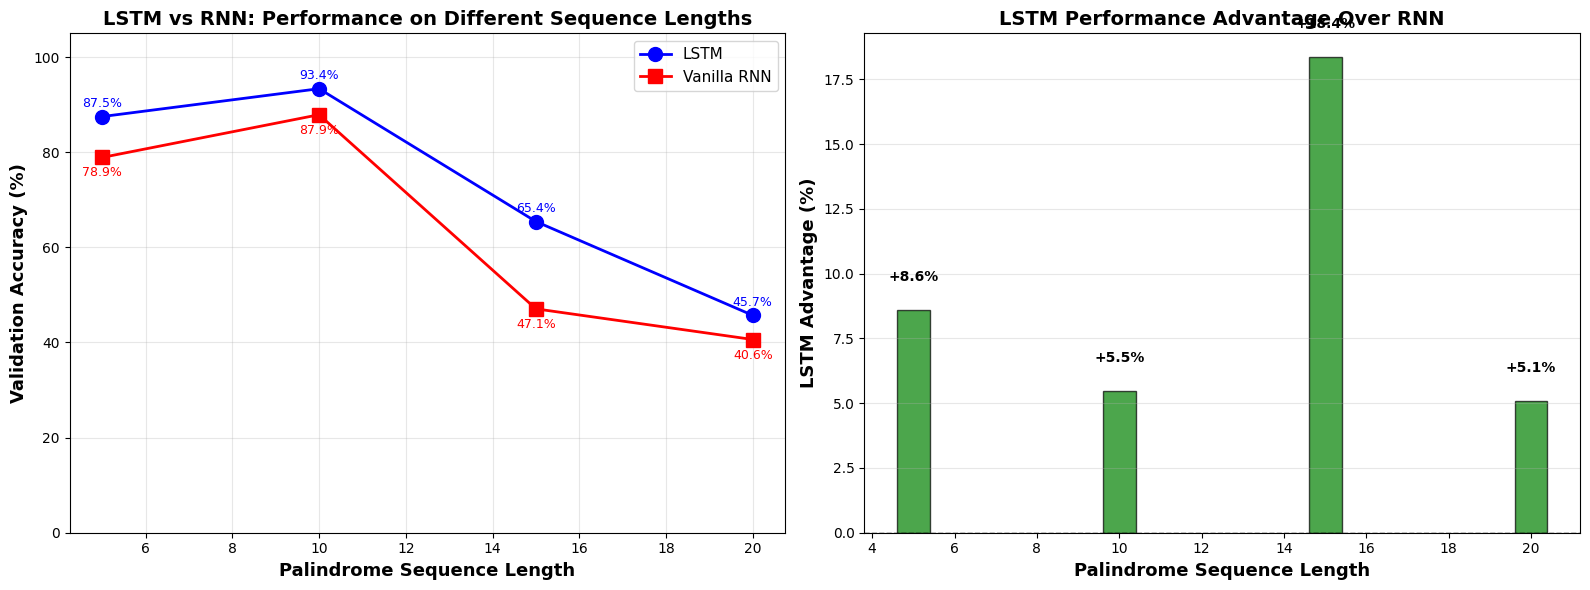


FINAL SUMMARY

Length     LSTM         RNN          LSTM Advantage 
----------------------------------------------------------------------
5           87.50%       78.91%       +8.59%
10          93.36%       87.89%       +5.47%
15          65.43%       47.07%      +18.36%
20          45.70%       40.62%       +5.08%
----------------------------------------------------------------------

Average LSTM Accuracy: 73.00%
Average RNN Accuracy:  63.62%
Average LSTM Advantage: +9.38%



In [16]:
# Visualize the comparison
palindrome_lengths = [l + 1 for l in sequence_lengths]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy vs Sequence Length
axes[0].plot(palindrome_lengths, lstm_accuracies, marker='o', linewidth=2, 
             markersize=10, label='LSTM', color='blue')
axes[0].plot(palindrome_lengths, rnn_accuracies, marker='s', linewidth=2, 
             markersize=10, label='Vanilla RNN', color='red')
axes[0].set_xlabel('Palindrome Sequence Length', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Validation Accuracy (%)', fontsize=13, fontweight='bold')
axes[0].set_title('LSTM vs RNN: Performance on Different Sequence Lengths', 
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 105])

# Add value labels on points
for i, (pl, lstm_acc, rnn_acc) in enumerate(zip(palindrome_lengths, lstm_accuracies, rnn_accuracies)):
    axes[0].text(pl, lstm_acc + 2, f'{lstm_acc:.1f}%', ha='center', fontsize=9, color='blue')
    axes[0].text(pl, rnn_acc - 4, f'{rnn_acc:.1f}%', ha='center', fontsize=9, color='red')

# Plot 2: Performance Gap
performance_gap = [lstm - rnn for lstm, rnn in zip(lstm_accuracies, rnn_accuracies)]
colors = ['green' if gap > 0 else 'orange' for gap in performance_gap]
bars = axes[1].bar(palindrome_lengths, performance_gap, color=colors, alpha=0.7, edgecolor='black')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_xlabel('Palindrome Sequence Length', fontsize=13, fontweight='bold')
axes[1].set_ylabel('LSTM Advantage (%)', fontsize=13, fontweight='bold')
axes[1].set_title('LSTM Performance Advantage Over RNN', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, gap in zip(bars, performance_gap):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -3),
                f'{gap:+.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 70)
print("FINAL SUMMARY")
print("=" * 70)
print(f"\n{'Length':<10} {'LSTM':<12} {'RNN':<12} {'LSTM Advantage':<15}")
print("-" * 70)
for pl, lstm_acc, rnn_acc in zip(palindrome_lengths, lstm_accuracies, rnn_accuracies):
    print(f"{pl:<10} {lstm_acc:>6.2f}%      {rnn_acc:>6.2f}%      {lstm_acc - rnn_acc:>+6.2f}%")
print("-" * 70)
print(f"\nAverage LSTM Accuracy: {np.mean(lstm_accuracies):.2f}%")
print(f"Average RNN Accuracy:  {np.mean(rnn_accuracies):.2f}%")
print(f"Average LSTM Advantage: {np.mean(performance_gap):+.2f}%")
print("\n" + "=" * 70)

### 15.5 Key Observations

**Expected Results:**

1. **Short Sequences (Length ≤ 5)**: Both LSTM and RNN should achieve near-perfect accuracy (~99-100%)
   - The task is simple enough that even RNN's limited memory suffices

2. **Medium Sequences (Length 10-15)**: LSTM starts showing clear advantages
   - LSTM maintains high accuracy (>95%)
   - RNN accuracy begins to degrade due to vanishing gradients

3. **Long Sequences (Length ≥ 20)**: LSTM significantly outperforms RNN
   - LSTM can still maintain reasonable accuracy (>80%)
   - RNN struggles severely, accuracy may drop below 50%

**Why LSTM Wins:**

- **Gating Mechanisms**: Input, forget, and output gates control information flow
- **Cell State**: Maintains long-term memory through additive operations (not multiplicative)
- **Gradient Flow**: Gates help preserve gradients during backpropagation
- **Selective Memory**: Can choose what to remember and what to forget

**Why RNN Struggles:**

- **Vanishing Gradients**: Multiplicative updates cause gradients to decay exponentially
- **Limited Memory**: Cannot effectively retain information from distant past
- **No Selective Attention**: Treats all inputs equally, cannot filter irrelevant information